In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
class RFAData:
    def __init__(self, filename):
        """Initialize RFA data from a measurement file."""
        # Header information
        self.measurement_date = None
        self.operator = ""
        self.comments = ""
        self.projectile = ""
        
        # Beam parameters
        self.energy = 0.0
        self.extractor = 0.0
        self.focus1 = 0.0
        self.focus2 = 0.0
        
        # RFA parameters
        self.suppressor_voltage = 0.0
        self.rfa_comments = ""
        self.ret_config = ""
        self.supp_config = ""
        
        # Wien filter
        self.wien_voltage = 0.0
        
        # Sweep parameters
        self.sweep_start = 0.0
        self.sweep_end = 0.0
        self.sweep_step = 0.0
        self.measurement_time = 0.0
        self.integration_time = 0.0
        self.plc = 0.0
        self.points_per_step = 0.0
        
        # Measurement data
        self.retarding_voltage = None  # Will be numpy array
        self.mean_current = None       # Will be numpy array
        
        self._load_file(filename)
        self._read_configuration()
        self._remove_first_point()
    
    def _load_file(self, filename):
        """Load and parse the measurement file."""
        with open(filename, 'r') as file:
            lines = file.readlines()
            
        # Parse header information
        data_start_index = None
        in_rfa_section = False  # Flag to track if we're in the RFA section


        # first, record date (that doesn't fit the standard ":" format):
        datetime_str = lines[0].strip().replace("Measured on ", "")
        self.measurement_date = datetime.strptime(datetime_str, "%H:%M:%S %d/%m/%Y")
        
        for i, line in enumerate(lines):
            line = line.strip()
            
            if not line:
                continue
            
            # Check for data section
            if "Retading voltage (kV)" in line and "Mean current FC (A)" in line:
                data_start_index = i + 1
                break
                
            # Check if we're entering RFA section
            if "RFA#:" in line:
                in_rfa_section = True
                
            # Handle fields that might be empty
            if ":" in line:
                parts = line.split(':', 1)  # Split on first colon only
                field = parts[0].strip()
                value = parts[1].strip() if len(parts) > 1 else ""
                
                # Remove any remaining tabs
                value = value.replace('\t', '').strip()
                    
                if field == "Operated by":
                    self.operator = value
                elif field == "Comments":
                    # Assign to appropriate comments field based on section
                    if in_rfa_section:
                        self.rfa_comments = value
                    else:
                        self.comments = value
                elif field == "Projectile":
                    self.projectile = value
                elif field == "Energy (V)":
                    self.energy = float(value)/1000 if value else 0.0 # also convert to V
                elif field == "Extractor (%)":
                    self.extractor = float(value) if value else 0.0
                elif field == "Focus 1 (%)":
                    self.focus1 = float(value) if value else 0.0
                elif field == "Focus 2 (%)":
                    self.focus2 = float(value) if value else 0.0
                elif field == "Suppressor voltage (V)":
                    self.suppressor_voltage = float(value) if value else 0.0
                elif field == "Wien voltage (V)":
                    self.wien_voltage = float(value) if value else 0.0
                elif field == "Sweep start (kV)":
                    self.sweep_start = float(value) if value else 0.0
                elif field == "Sweep end (kV)":
                    self.sweep_end = float(value) if value else 0.0
                elif field == "Sweep step (V)":
                    self.sweep_step = float(value) if value else 0.0
                elif field == "Measurement time (s)":
                    self.measurement_time = float(value) if value else 0.0
                elif field == "Integration time (s)":
                    self.integration_time = float(value) if value else 0.0
                elif field == "PLC":
                    self.plc = float(value) if value else 0.0
                elif field == "Points per step":
                    self.points_per_step = float(value) if value else 0.0
        
        if data_start_index is None:
            raise ValueError("Could not find data section in file")
            
        # Parse measurement data
        data_lines = [line.strip() for line in lines[data_start_index:] if line.strip()]
        voltage_data = []
        current_data = []
        
        for line in data_lines:
            v, i = line.split('\t')
            voltage_data.append(float(v.replace('E', 'e')))
            current_data.append(float(i.replace('E', 'e')))
        
        self.retarding_voltage = np.array(voltage_data)
        self.mean_current = np.array(current_data)

    def _read_configuration(self):
            """Set RFA configuration based on measurement date"""
            date_configs = {
                "2024-11-27": (1, "2grid", "1grid"),
                "2024-11-29": (2, "2grid", "d_small"),
                "2024-12-04": (3, "1grid", "1grid"),
                "2024-12-06": (4, "1grid", "d_big")
            }
            
            date_str = self.measurement_date.strftime(r"%Y-%m-%d")
            if date_str in date_configs:
                self.measurement_day, self.ret_config, self.supp_config = date_configs[date_str]

    def _remove_first_point(self):
        """Remove first point from measurement data arrays, as that is most often erroneous."""
        if len(self.retarding_voltage) > 0 and len(self.mean_current) > 0:
            self.retarding_voltage = self.retarding_voltage[1:]
            self.mean_current = self.mean_current[1:]
    
    def __repr__(self):
        return (f"RFAData: \n"
                f"\tretarding configuration = {self.ret_config}, \n"
                f"\tsuppressor configuration = {self.supp_config}, \n"
                f"\tbeam energy  = {self.energy} kV, \n"
                f"\tsweep starting voltage = {self.sweep_start} kV, \n"
                f"\tsuppressor voltage = {self.suppressor_voltage}")

RFAData: 
	retarding configuration = 1grid, 
	suppressor configuration = d_big, 
	beam energy  = 2.0 V, 
	sweep starting voltage = 1.8 kV, 
	suppressor voltage = -500.0


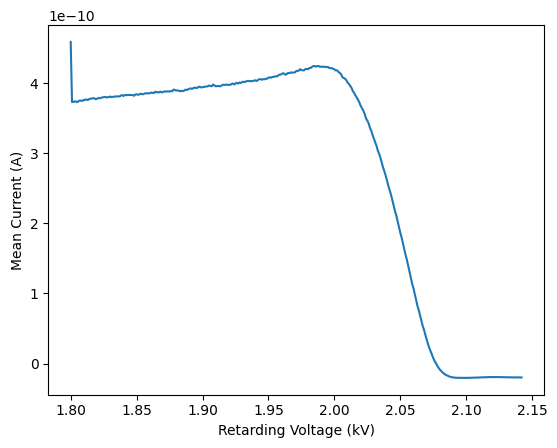

In [93]:
# Load a measurement file
rfa_data = RFAData(r"raw data\2024-12-06\rfa-peak 1-supp500 - 2k.txt")

# Access the data
print(rfa_data)

# Plot the data
plt.plot(rfa_data.retarding_voltage, rfa_data.mean_current)
plt.xlabel('Retarding Voltage (kV)')
plt.ylabel('Mean Current (A)')
plt.show()

In [89]:
rfa_data.__dict__

{'measurement_date': datetime.datetime(2024, 12, 6, 11, 59, 35),
 'operator': 'Ennio Kristof',
 'comments': '',
 'projectile': 'Ar',
 'energy': 2000.0,
 'extractor': 98.0,
 'focus1': 67.0,
 'focus2': 0.0,
 'suppressor_voltage': -500.0,
 'rfa_comments': '2 grid retar, no grid big diameter supp.',
 'ret_config': '1grid',
 'supp_config': 'd_big',
 'wien_voltage': 97.7,
 'sweep_start': 1.8,
 'sweep_end': 2.2,
 'sweep_step': 1.0,
 'measurement_time': 0.1,
 'integration_time': 0.1,
 'plc': 5.0,
 'points_per_step': 1.0,
 'retarding_voltage': array([1.8  , 1.801, 1.802, 1.803, 1.804, 1.805, 1.806, 1.807, 1.808,
        1.809, 1.81 , 1.811, 1.812, 1.813, 1.814, 1.815, 1.816, 1.817,
        1.818, 1.819, 1.82 , 1.821, 1.822, 1.823, 1.824, 1.825, 1.826,
        1.827, 1.828, 1.829, 1.83 , 1.831, 1.832, 1.833, 1.834, 1.835,
        1.836, 1.837, 1.838, 1.839, 1.84 , 1.841, 1.842, 1.843, 1.844,
        1.845, 1.846, 1.847, 1.848, 1.849, 1.85 , 1.851, 1.852, 1.853,
        1.854, 1.855, 1.856, 1.857